# Spectral analysis

## Loading of the spectral data and references

In [86]:
import numpy as np

kiwi_spectra = np.loadtxt("results/kiwi_avg_spectra.csv", delimiter=",")
reference_values = np.loadtxt("data/reference.csv", delimiter=",")
reference_values = reference_values[:180, :]
reference_values.shape

(180, 2)

## Outliers removal (unsupervised, PCA)

Due to potential mishaps in our measurements or extraction of spectra per kiwi and various other reasons we may end up having outliers in our dataset. These outliers can cause problems when training chemometrics/machine learning model. Let's explore unsupervised outlier removal

/tmp/ipykernel_1787/2388545682.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')


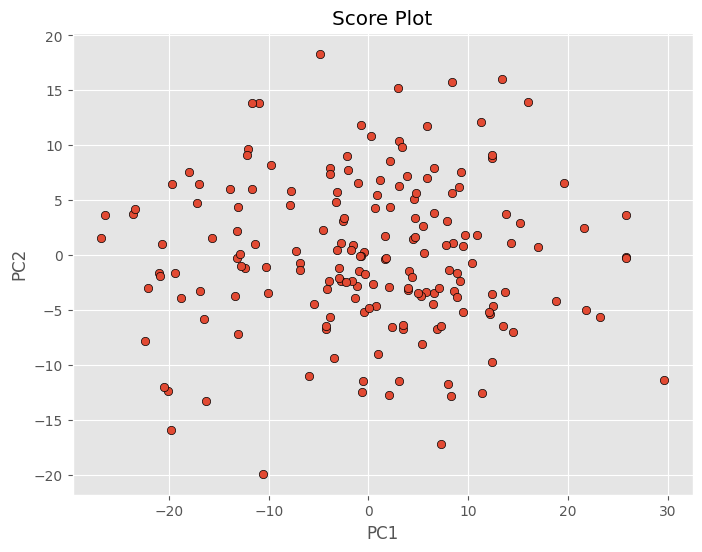

In [115]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
 
pca = PCA()
 
# Run PCA on scaled data (since PCA is sensitive to feature scale) and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(kiwi_spectra))
 
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

## Outlier removal from references

It's a hard task to analyze every spectra across all wavelengths. By computing principal components we can identify where most of variance in our data is and focus on a few first components. After simplifying our data to first let's say 5 components, we can detect outliers by computing distance of each point to the rest. The straightforward way is to compute Euclidean distance, but:
  - It assumes variables are uncorrelated, which can be misleading when there's correlation between axes (e.g. tilted ellipsoids in PCA score plots).
  - Redundant or correlated variables can distort distance measures, unintentionally amplifying their influence.
  - It is sensitive to outliers, which skew mean and standard deviation—making it hard to identify those same outliers.

**Solution: Mahalanobis Distance**
  - Accounts for the **covariance structure** of the data, giving less weight to directions with high variance (i.e., redundancy).
  - Can be calculated robustly using **Minimum Covariance Determinant (MCD)** from `sklearn.covariance`.
  - When applied to PCA-transformed data (e.g., first 5 components), it highlights observations that deviate from the multivariate distribution.

In [116]:
from sklearn.covariance import MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet(random_state=42).fit(T[:,:5])
 
# Get the Mahalanobis distance
mahalanobis = robust_cov.mahalanobis(T[:,:5])

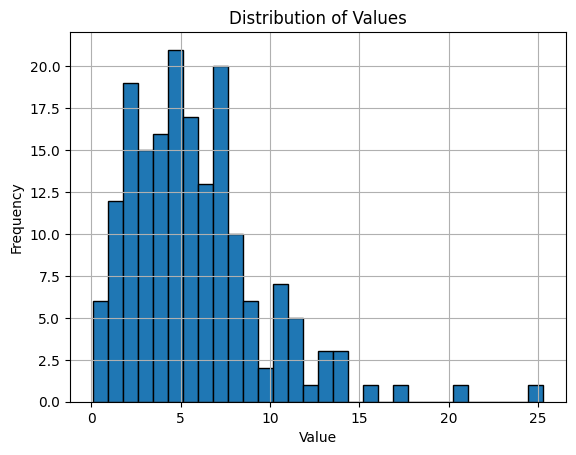

In [117]:
# Plot histogram
plt.hist(mahalanobis, bins=30, edgecolor='black') 
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

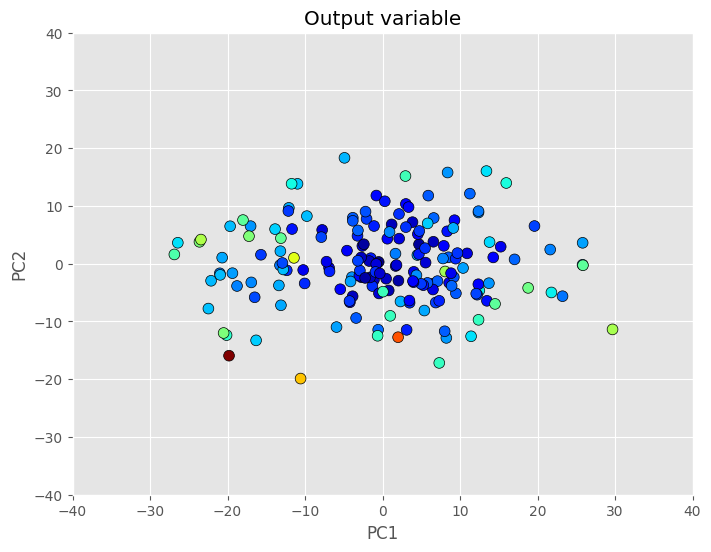

In [118]:
colors = [plt.cm.jet(float(i)/max(mahalanobis)) for i in mahalanobis]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    plt.title('Output variable')
plt.show()

In [119]:
from scipy.stats import chi2

threshold = chi2.ppf(0.99, df=5)
outliers = mahalanobis > threshold
outlier_indices_input = np.where(outliers)[0]

print("Outlier indices:", outlier_indices_input)

Outlier indices: [ 22  45 142 177]


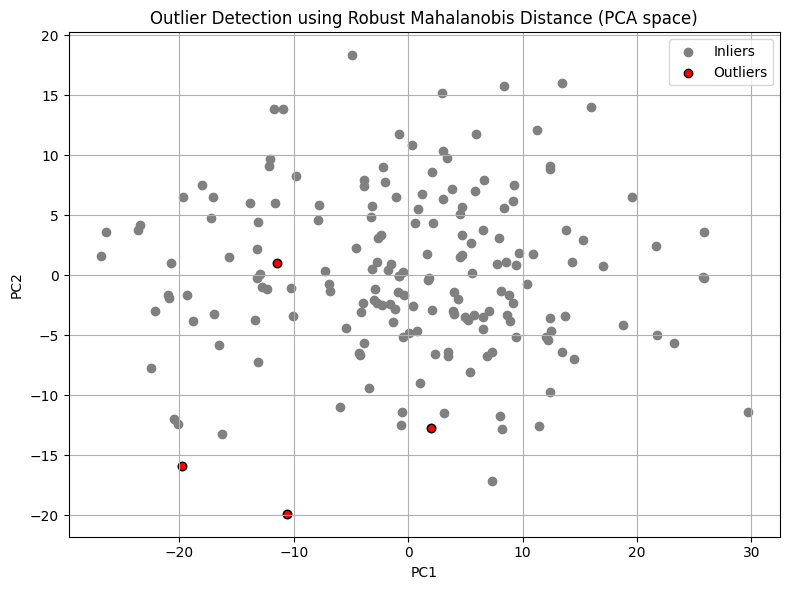

In [120]:
plt.figure(figsize=(8, 6))
plt.scatter(T[:, 0], T[:, 1], c='gray', label='Inliers')
plt.scatter(T[outliers, 0], T[outliers, 1], c='red', label='Outliers', edgecolors='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Outlier Detection using Robust Mahalanobis Distance (PCA space)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outlier removal from spectra

Let's repeat the same exercise for our output variable. Since we only have two target variables it does not make sense to compute PCA, since it's a dimension-reduction technique. Let's compute mahalanobis distance based on rbust covariance matrix of the output variables.

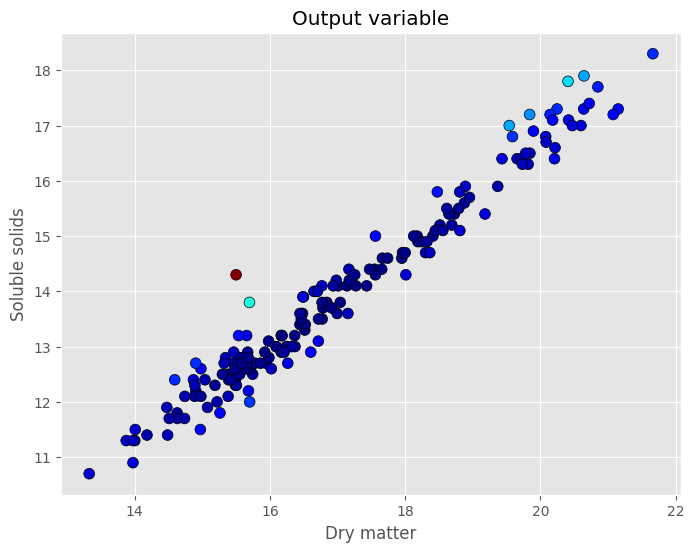

In [121]:
robust_cov = MinCovDet(random_state=42).fit(reference_values)

mahalanobis = robust_cov.mahalanobis(reference_values)

colors = [plt.cm.jet(float(i)/max(mahalanobis)) for i in mahalanobis]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(reference_values[:, 0], reference_values[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('Dry matter')
    plt.ylabel('Soluble solids')
    plt.title('Output variable')
plt.show()

In [122]:
threshold = chi2.ppf(0.99, df=2)
outliers = mahalanobis > threshold
outlier_indices_output = np.where(outliers)[0]

print("Outlier indices (based on output variables):", outlier_indices_output)

Outlier indices (based on output variables): [ 35  71  77 100 135 150 154 155 159]


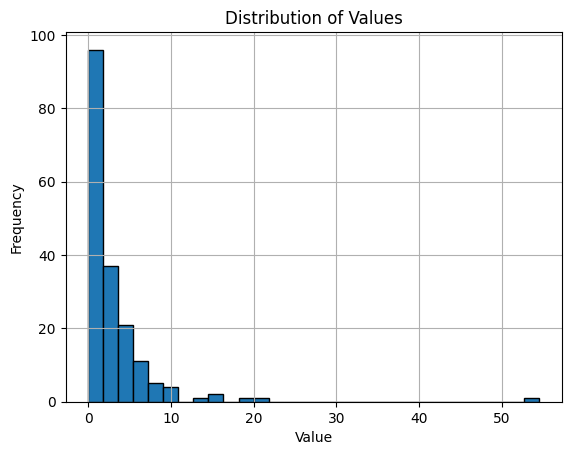

In [123]:
# Plot histogram
plt.hist(mahalanobis, bins=30, edgecolor='black')  
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

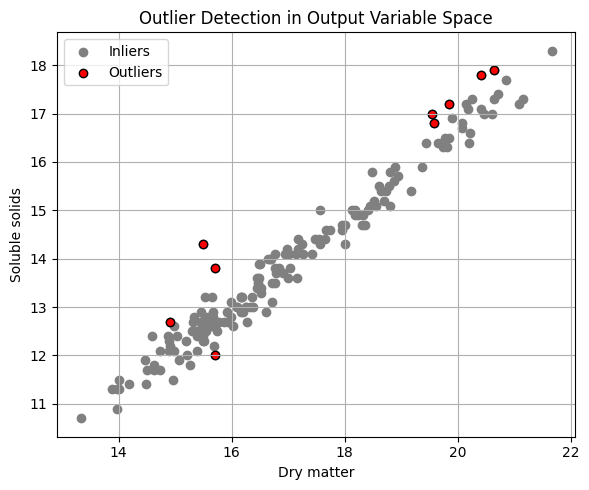

In [124]:
plt.figure(figsize=(6, 5))
plt.scatter(reference_values[:, 0], reference_values[:, 1], c='gray', label='Inliers')
plt.scatter(reference_values[outliers, 0], reference_values[outliers, 1], c='red', edgecolors='k', label='Outliers')
plt.xlabel('Dry matter')
plt.ylabel('Soluble solids')
plt.title('Outlier Detection in Output Variable Space')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
# Combine unique outlier indices from both sources
combined_outliers = np.union1d(outlier_indices_input, outlier_indices_output)

# Remove those rows from input and output data
X_clean = np.delete(kiwi_spectra, combined_outliers, axis=0)
Y_clean = np.delete(reference_values, combined_outliers, axis=0)

print(f"Removed {len(combined_outliers)} outliers. Cleaned data shape:")
print("X_clean:", X_clean.shape)
print("Y_clean:", Y_clean.shape)

Removed 13 outliers. Cleaned data shape:
X_clean: (167, 224)
Y_clean: (167, 2)


## Pre-processing of data

### Smoothing

In [98]:
from scipy.signal import savgol_filter
 
X_example = X_clean[0, :]
wl = np.loadtxt("results/wavelengths.csv", delimiter=",")

w = 5
p = 2
X_smooth_1 = savgol_filter(X_example, w, polyorder = p, deriv=0)

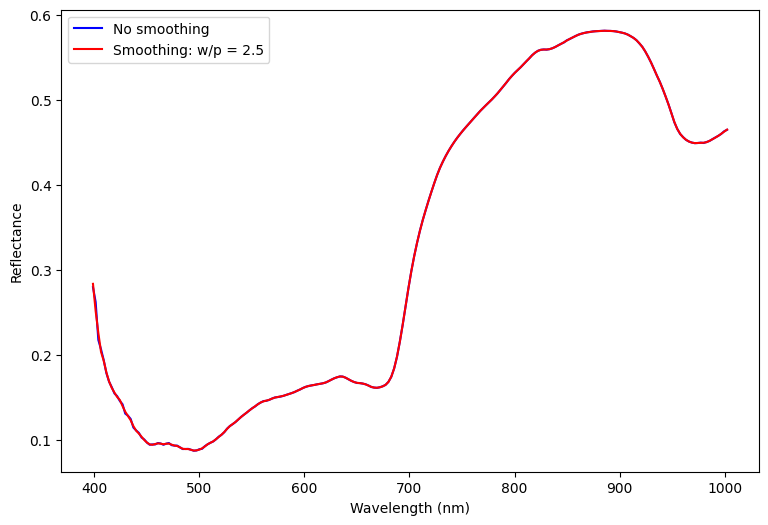

In [99]:
plt.figure(figsize=(9,6))
interval = np.arange(0,224,1)
plt.plot(wl[interval], X_example[interval], 'b', label = 'No smoothing')
plt.plot(wl[interval], X_smooth_1[interval], 'r', label = 'Smoothing: w/p = 2.5')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.show()

In [100]:
X = savgol_filter(X_clean, w, polyorder = p, deriv=0)

It does look quite smooth already, probably because of averaging?

## Scatter correction

In [101]:
def snv(input_data):
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [102]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

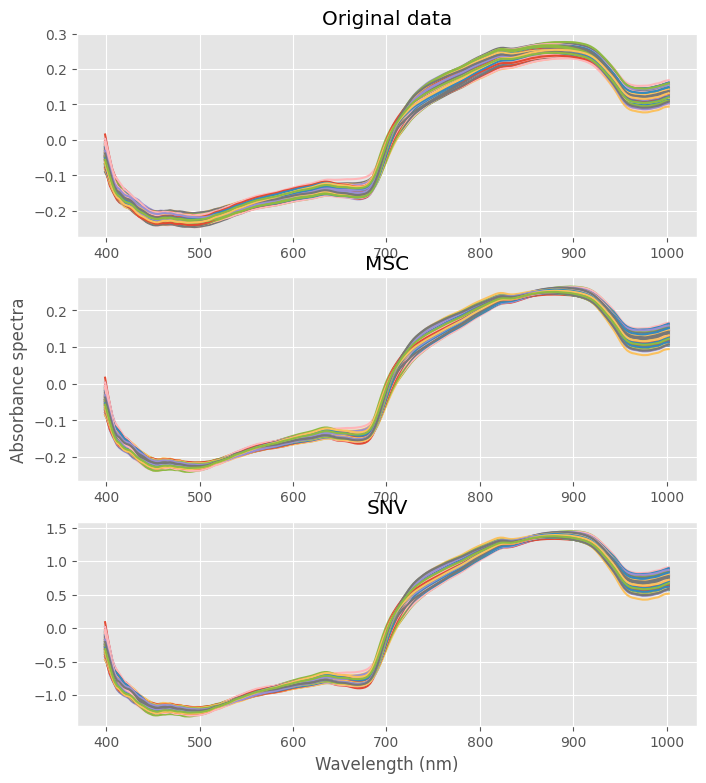

In [103]:
import matplotlib.pyplot as plt
 
Xmsc = msc(X)[0] # Take the first element of the output tuple
Xsnv = snv(X)
 
## Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(wl, X.T)
    plt.title('Original data')
 
    ax2 = plt.subplot(312)
    plt.plot(wl, Xmsc.T)
    plt.ylabel('Absorbance spectra')
    plt.title('MSC')
 
    ax2 = plt.subplot(313)
    plt.plot(wl, Xsnv.T)
    plt.xlabel('Wavelength (nm)')
    plt.title('SNV')
    plt.show()

In [104]:
Xmsc = msc(X)[0]

It looks like shape is the same, but MSC is saving the original range

### Derivative

What did we mean with derivative? is it best to take derivative of the signal? it seems you can supply derivative order to savitzky-golay

### Automated pre-processing (nippy)

In [113]:
# A simple example of semi-automic preprocessing of NIR data using nippy.
#
# jtorniainen // UEF
# 2019, MIT License

import nippy

pipelines = nippy.read_configuration('example_pipelines.ini')

# 2. Load data
data = kiwi_spectra.T #nippy works with the format where Rows = wavelength, Columns = samples

processed_spectra = []

iterator = nippy.Preprocessor(wl, data, 'example_pipelines.ini')

for wavelength_, spectra_, pipe_ in iterator:
    print(spectra_.shape)
    processed_spectra.append(spectra_)

(0, 180)
(0, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(1, 180)
(0, 180)
(0, 180)
(0, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(1, 180)
(0, 180)
(0, 180)
(1, 180)
(1, 180)
(0, 180)
(0, 180)


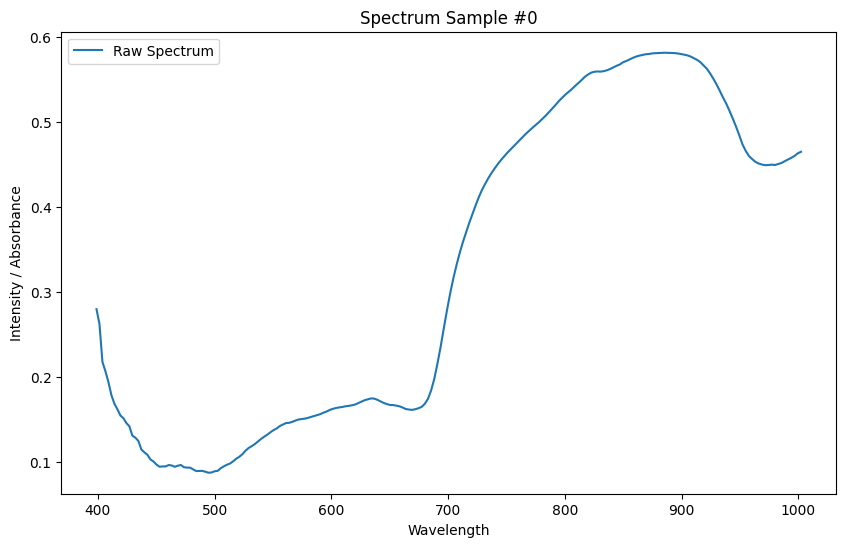

In [114]:
def plot_spectra(wavelength, raw_spectra, processed_spectra, sample_idx=0):
    """
    Plot raw and preprocessed spectra for a given sample index.

    Args:
        wavelength (np.ndarray): Vector of wavelengths.
        raw_spectra (np.ndarray): Raw spectra matrix (wavelength x samples).
        processed_spectra (np.ndarray): Processed spectra matrix.
        sample_idx (int): Index of the sample to plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, raw_spectra[:, sample_idx], label='Raw Spectrum')
    #TODO fix thepipeline to return spectra for all samples?
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity / Absorbance')
    plt.title(f'Spectrum Sample #{sample_idx}')
    plt.legend()
    plt.show()

# Example usage:
# wavelength, raw_spectra are your data
# processed_spectra = ... (result of your preprocessing pipeline)
plot_spectra(wl, data, processed_spectra, sample_idx=0)

## Data partition

Kennard-Stone partition

In [131]:
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate

X_train, X_test, y_train, y_test = ks.train_test_split(X, Y_clean[:,0], test_size = 0.2)

/home/liza/miniforge3/envs/hyperspectral/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-06 16:26:07,223 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

/home/liza/miniforge3/envs/hyperspectral/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-06 16:26:07,225 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

/home/liza/miniforge3/envs/hyperspectral/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


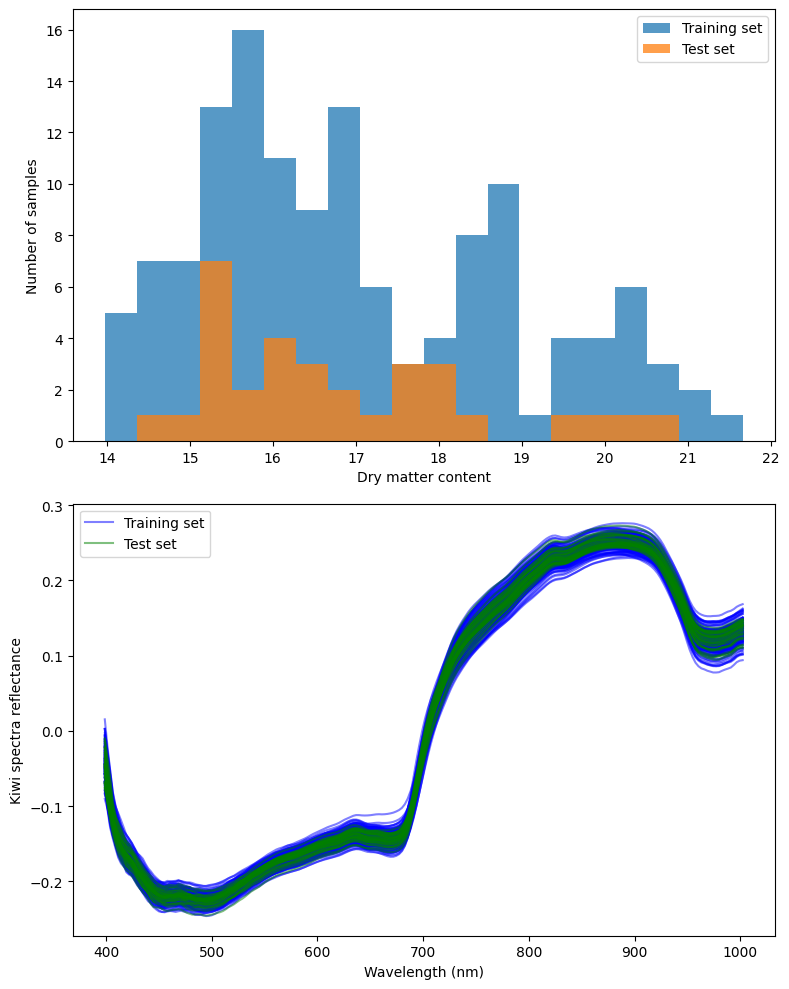

In [134]:

f, axs = plt.subplots(2,1,figsize=(8,10))
n, bins, patches = axs[0].hist(y_train, bins = 20, alpha=0.75, label="Training set")
axs[0].hist(y_test, bins = bins, alpha=0.75, label="Test set")
axs[0].legend()
axs[0].set_xlabel("Dry matter content") 
axs[0].set_ylabel("Number of samples")

train_legend =  np.repeat("_Training set", X_train.shape[0])
train_legend[0] = "Training set"
test_legend =  np.repeat("_Test set", X_test.shape[0])
test_legend[0] = "Test set"

axs[1].plot(wl, X_train.T, 'b', alpha=0.5, label = train_legend)
axs[1].plot(wl, X_test.T, 'g', alpha=0.5, label = test_legend)
axs[1].legend()
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Kiwi spectra reflectance")
plt.tight_layout()
plt.show()

In [136]:
# TODO expand to both metrics

Duplex partition (some more coming)

## Spectral calibration

Principal component regression

In [137]:

''' Step 1: PCA on input data'''
 
# Define the PCA object
pca = PCA()
 
# Preprocessing (1): first derivative
d1X = savgol_filter(X_clean, 25, polyorder = 5, deriv=1)
 
# Preprocess (2) Standardize features by removing the mean and scaling to unit variance
Xstd = StandardScaler().fit_transform(d1X[:,:])
 
# Run PCA producing the reduced variable Xreg and select the first 5 pc components
Xreg = pca.fit_transform(Xstd)[:,:5]

In [140]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object 
regr = linear_model.LinearRegression() 
# Fit 
regr.fit(Xreg, Y_clean) 
# Calibration 
y_c = regr.predict(Xreg) 
# Cross-validation 
y_cv = cross_val_predict(regr, Xreg, Y_clean, cv=10) 
# Calculate scores for calibration and cross-validation 
score_c = r2_score(Y_clean, y_c) 
score_cv = r2_score(Y_clean, y_cv)
# Calculate mean square error for calibration and cross validation 
mse_c = mean_squared_error(Y_clean, y_c) 
mse_cv = mean_squared_error(Y_clean, y_cv)

print("R^2 score when using the whole data:", score_c)
print("R^2 score when using cross-validation:", score_cv)
print("MSE score when using the whole data:", mse_c)
print("MSE score when using cross-validation:", mse_cv)

R^2 score when using the whole data: 0.590224282253615
R^2 score when using cross-validation: 0.4876021167351607
MSE score when using the whole data: 1.276602166845782
MSE score when using cross-validation: 1.595688870795688


In [ ]:
#TODO choose x-train, y-train from partition method, see how MSE works with multiple output variables

PLSR 

Supervised outlier removal with PLS (& explain cross-validation)

Model diagnostics

Deep learning methods (simple convolution)